# Automatic scoring of x-ray images

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras.python.keras.utils.io_utils import HDF5Matrix
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Activation
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

Import data as HDF5 Matrix

In [3]:
# one hot encode labels

with h5py.File('/data/joint_scoring/labels_train_combined_regression.h5', 'r') as hf:
    labels_train = hf['labels_train_combined_regression'][:]
    
with h5py.File('/data/joint_scoring/labels_test_regression.h5', 'r') as hf:
    labels_test = hf['labels_test_regression'][:]
    
def cdf(label):
    arr = np.zeros(101)
    arr[int(label):] = 1
    return arr

labels_train = [cdf(x) for x in labels_train]
labels_test = [cdf(x) for x in labels_test]

In [4]:
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

In [5]:
print(labels_train.shape)
print(labels_test.shape)

(210025, 101)
(19709, 101)


In [6]:
with h5py.File('/data/joint_scoring/labels_train_combined_regression_cdf.h5', 'w') as hf:
    hf.create_dataset("labels_train_combined_regression_cdf",  data=labels_train)
    
with h5py.File('/data/joint_scoring/labels_test_regression_cdf.h5', 'w') as hf:
    hf.create_dataset("labels_test_regression_cdf",  data=labels_test)

In [7]:
img_train = HDF5Matrix('/data/joint_scoring/img_train_combined_regression.h5', 'img_train_combined_regression')
img_test = HDF5Matrix('/data/joint_scoring/img_test_regression.h5', 'img_test_regression')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_combined_regression_cdf.h5', 'labels_train_combined_regression_cdf')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_regression_cdf.h5', 'labels_test_regression_cdf')

In [8]:
def crps(y_true, y_pred):
    diff = (y_true - y_pred)
    diff_2 = K.square(diff)
    loss = K.mean(diff_2)
    return loss

## 2. Model

In [9]:
def conv_model():
    # create model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255., input_shape=(150, 150, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=8192, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=4096, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=101, kernel_initializer="he_normal", activation="sigmoid"))

    # Compile model
    model.compile(optimizer="adam", loss=crps,
                  metrics=[crps, "mae"])

    return model

In [10]:
# build the model
model = conv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
__________

In [11]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [12]:
print(new_folder)

20171103_133826


In [13]:
desc = "Regression model with CRPS on oversampled data"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [14]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [15]:
# Fit the model
model.fit(x=img_train, y=labels_train, batch_size=100, epochs=25, verbose=1,
          callbacks=[tb_callback], validation_data=(img_test, labels_test),
          shuffle="batch")

Train on 210025 samples, validate on 19709 samples
Epoch 1/25
210025/210025 [==============================] - 810s - loss: 0.1027 - crps: 0.1027 - mean_absolute_error: 0.1988 - val_loss: 0.0324 - val_crps: 0.0324 - val_mean_absolute_error: 0.0576
Epoch 2/25
210025/210025 [==============================] - 715s - loss: 0.0854 - crps: 0.0854 - mean_absolute_error: 0.1679 - val_loss: 0.0309 - val_crps: 0.0309 - val_mean_absolute_error: 0.0482
Epoch 3/25
210025/210025 [==============================] - 716s - loss: 0.0753 - crps: 0.0753 - mean_absolute_error: 0.1486 - val_loss: 0.0273 - val_crps: 0.0273 - val_mean_absolute_error: 0.0547
Epoch 4/25
210025/210025 [==============================] - 716s - loss: 0.0676 - crps: 0.0676 - mean_absolute_error: 0.1334 - val_loss: 0.0280 - val_crps: 0.0280 - val_mean_absolute_error: 0.0458
Epoch 5/25
210025/210025 [==============================] - 718s - loss: 0.0614 - crps: 0.0614 - mean_absolute_error: 0.1211 - val_loss: 0.0318 - val_crps: 0.031

KeyboardInterrupt: 

In [16]:
# Final evaluation of the model
scores = model.evaluate(img_test, labels_test, verbose=0)
print(scores)

[0.029844549061583354, 0.029844549061583354, 0.043508371383895295]


In [17]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [18]:
from sklearn.metrics import classification_report
p = model.predict_proba(img_test)

19680/19709 [============================>.] - ETA: 0s

In [20]:
labels_test_reg = HDF5Matrix('/data/joint_scoring/labels_test_regression.h5', 'labels_test_regression')


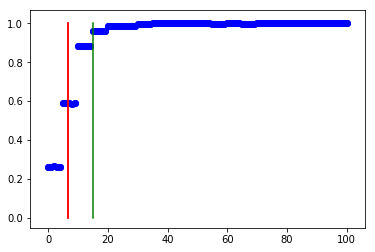

6.75147122145


In [21]:
idx = 3

# see proof here: https://stats.stackexchange.com/questions/10159/find-expected-value-using-cdf
ex = sum(1 - p[idx])

plt.scatter(x=range(101), y=p[idx].tolist(), color = "blue") # cdf predictions

plt.plot((ex, ex), (0, 1), 'k-', color = "red") # expected value of prediction
plt.plot((labels_test_reg[idx], labels_test_reg[idx]), (0, 1), 'k-', color = "green") # true value

plt.show()

print(ex)

In [22]:
pred = np.zeros(p.shape[0])

for i in range(p.shape[0]):
    pred[i] = sum(1 - p[i])

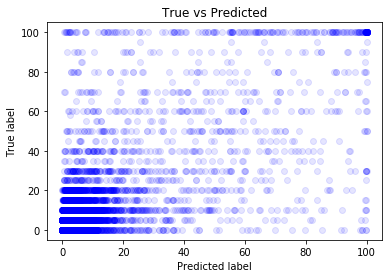

In [25]:
plt.title("True vs Predicted")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.scatter(x=pred, y=labels_test_reg, color="blue", alpha=0.1)

plt.show()

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [29]:
mean_absolute_error(y_true=labels_test_reg, y_pred=pred)

4.0286207290035421

In [30]:
mean_squared_error(y_true=labels_test_reg, y_pred=pred)

98.476952109655059

In [31]:
r2_score(y_true=labels_test_reg, y_pred=pred)

0.53006181233251493

In [27]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray_regression_crps_oversampled.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)